In [1]:
import awkward as ak
import matplotlib.pyplot as plt
import numpy as np

In [2]:
from fastjet_contribs import compute_nsubjettiness

ModuleNotFoundError: No module named 'fastjet_contribs'

In [ ]:
dataset = ak.from_parquet("/remote/gpu04/petitjean/high-dim-unfolding/data/ttbar/particles_merged.parquet")

In [ ]:
nsub = dataset["nsub"]

In [ ]:
gen_particles = dataset["gen_particles"]
rec_particles = dataset["rec_particles"]
gen_jets = dataset["gen_jets"]
rec_jets = dataset["rec_jets"]

In [ ]:
np.array(rec_particles[0,...,3])

array([ 1.39569998e-01,  1.39569998e-01,  1.39569998e-01,  1.39569998e-01,
        1.39569998e-01,  4.21468478e-08, -5.96046448e-08,  1.39569998e-01,
        2.98023224e-08,  5.96046448e-08,  1.39569998e-01,  0.00000000e+00,
        1.39569998e-01,  1.39569998e-01,  1.39569998e-01,  0.00000000e+00,
       -3.37174782e-07,  1.19209290e-07,  1.39569998e-01,  1.68587391e-07,
        0.00000000e+00, -2.06476543e-07,  1.39569998e-01,  1.39569998e-01,
        0.00000000e+00,  1.39569998e-01,  0.00000000e+00, -1.34869913e-06,
        4.21468478e-08, -8.42936956e-08,  1.39569998e-01,  1.39569998e-01,
       -4.76837158e-07,  0.00000000e+00,  0.00000000e+00,  1.19209290e-07,
        1.68587391e-07,  1.39569998e-01,  0.00000000e+00,  1.68587391e-07,
       -4.76837158e-07,  0.00000000e+00,  1.39569998e-01,  1.39569998e-01,
        1.39569998e-01,  1.39569998e-01,  0.00000000e+00,  3.37174782e-07,
        1.39569998e-01,  0.00000000e+00,  1.39569998e-01, -2.98023224e-08,
        1.39569998e-01,  

In [ ]:
gen_particles.type.show()
rec_particles.type.show()

1027145 * var * var * float64
1027145 * var * var * float64


In [ ]:
rec_jets[0], np.sum(rec_particles, axis=1)[0]

(<Array [441, 1.14, -1.71, 175] type='4 * float64'>,
 <Array [442, 71.6, -104, 3.49] type='4 * float64'>)

In [ ]:
def unpack_last(array):
    return array[..., 0], array[..., 1], array[..., 2], array[..., 3]

def jetmomenta_to_fourmomenta(jetmomenta):
    pt, phi, eta, m = unpack_last(jetmomenta)

    px = pt * np.cos(phi)
    py = pt * np.sin(phi)
    pz = pt * np.sinh(eta)
    E = np.sqrt(m**2 + px**2 + py**2 + pz**2)

    fourmomenta = ak.concatenate((E[..., None], px[..., None], py[..., None], pz[..., None]), axis=-1)
    return fourmomenta

def fourmomenta_to_jetmomenta(fourmomenta):
    E, px, py, pz = unpack_last(fourmomenta)
    
    pt = np.sqrt(px**2 + py**2)
    phi = np.arctan2(py, px)
    eta = np.arctanh(pz / E)
    m = np.sqrt(E**2 - px**2 - py**2 - pz**2)
    return ak.concatenate((pt[..., None], phi[..., None], eta[..., None], m[..., None]), axis=-1)

In [ ]:
gen_particles = jetmomenta_to_fourmomenta(gen_particles)
rec_particles = jetmomenta_to_fourmomenta(rec_particles)

In [ ]:
gen_jets = jetmomenta_to_fourmomenta(gen_jets)
rec_jets = jetmomenta_to_fourmomenta(rec_jets)

In [ ]:
summed_gen_jets = ak.sum(gen_particles,axis=1)
summed_rec_jets = ak.sum(rec_particles,axis=1)

In [ ]:
ak.to_numpy(rec_jets[1]), ak.to_numpy(summed_rec_jets[1])

(array([ 490.24180423,  118.75586116, -393.16961935, -246.73907075]),
 array([ 492.02163177,  118.75584609, -393.1696121 , -245.10273578]))

In [ ]:
print("Mean rec jet E:", ak.mean(rec_jets[..., 0]), ak.mean(summed_rec_jets[..., 0]))
print("Mean rec jet px:", ak.mean(rec_jets[..., 1]), ak.mean(summed_rec_jets[..., 1]))
print("Mean rec jet py:", ak.mean(rec_jets[..., 2]), ak.mean(summed_rec_jets[..., 2]))
print("Mean rec jet pz:", ak.mean(rec_jets[..., 3]), ak.mean(summed_rec_jets[..., 3]))

Mean rec jet E: 766.6182300319963 768.3712926649683
Mean rec jet px: -0.3440038680795303 -0.344003875810216
Mean rec jet py: -0.3381894922687098 -0.3381894559753
Mean rec jet pz: -0.17881009442022788 -0.17804229067290278


Text(0, 0.5, 'Density')

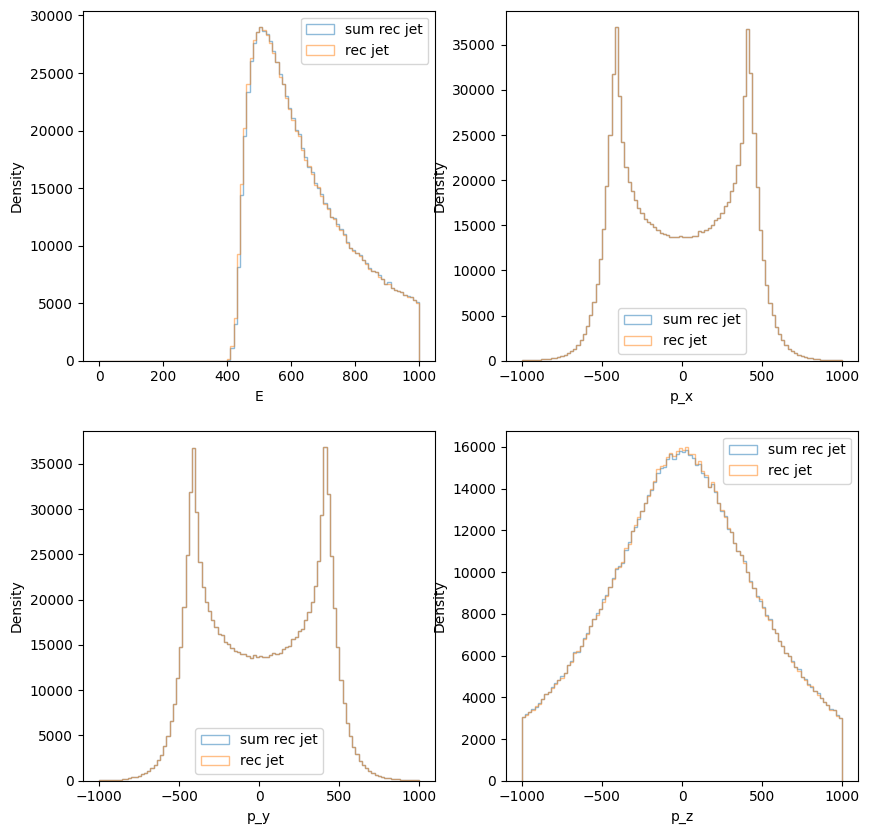

In [ ]:
fig, ax = plt.subplots(2,2,figsize=(10, 10))
#ax[0, 0].hist(gen_jets[:,3], bins=100, range=(150, 200), alpha=0.5, label="gen jet", histtype='step')
ax[0, 0].hist(summed_rec_jets[:,0], bins=100, range=(0, 1000), alpha=0.5, label="sum rec jet", histtype='step')
ax[0, 0].hist(rec_jets[:,0], bins=100, range=(0, 1000), alpha=0.5, label="rec jet", histtype='step')
ax[0, 0].legend()
ax[0, 0].set_xlabel("E")
ax[0, 0].set_ylabel("Density")
#ax[0, 1].hist(gen_jets[:,0], bins=100, range=(300, 1000), alpha=0.5, label="gen jet", histtype='step')
ax[0, 1].hist(summed_rec_jets[:,1], bins=100, range=(-1000, 1000), alpha=0.5, label="sum rec jet", histtype='step')
ax[0, 1].hist(rec_jets[:,1], bins=100, range=(-1000, 1000), alpha=0.5, label="rec jet", histtype='step')
ax[0, 1].legend()
ax[0, 1].set_xlabel("p_x")
ax[0, 1].set_ylabel("Density")
#ax[1, 0].hist(gen_jets[:,1], bins=100, range=(-5, 5), alpha=0.5, label="gen jet", histtype='step')
ax[1, 0].hist(summed_rec_jets[:,2], bins=100, range=(-1000, 1000), alpha=0.5, label="sum rec jet", histtype='step')
ax[1, 0].hist(rec_jets[:,2], bins=100, range=(-1000, 1000), alpha=0.5, label="rec jet", histtype='step')
ax[1, 0].legend()
ax[1, 0].set_xlabel("p_y")
ax[1, 0].set_ylabel("Density")
#ax[1, 1].hist(gen_jets[:,2], bins=100, range=(-5, 5), alpha=0.5, label="gen jet", histtype='step')
ax[1, 1].hist(summed_rec_jets[:,3], bins=100, range=(-1000, 1000), alpha=0.5, label="sum rec jet", histtype='step')
ax[1, 1].hist(rec_jets[:,3], bins=100, range=(-1000, 1000), alpha=0.5, label="rec jet", histtype='step')
ax[1, 1].legend()
ax[1, 1].set_xlabel("p_z")
ax[1, 1].set_ylabel("Density")

In [ ]:
gen_jets = fourmomenta_to_jetmomenta(gen_jets)
rec_jets = fourmomenta_to_jetmomenta(rec_jets)

/remote/gpu04/petitjean/high-dim-unfolding/venv/lib/python3.11/site-packages/awkward/_nplikes/array_module.py:251: RuntimeWarning: invalid value encountered in sqrt
  return impl(*broadcasted_args, **(kwargs or {}))


In [ ]:
summed_gen_jets = fourmomenta_to_jetmomenta(summed_gen_jets)
summed_rec_jets = fourmomenta_to_jetmomenta(summed_rec_jets)

In [ ]:
print(np.median(gen_jets[..., 3]), np.median(rec_jets[..., 3]))
print(np.median(summed_gen_jets[..., 3]), np.median(summed_rec_jets[..., 3]))

171.72837829589832 nan
171.7283857184397 nan


Text(0, 0.5, 'Number of jets')

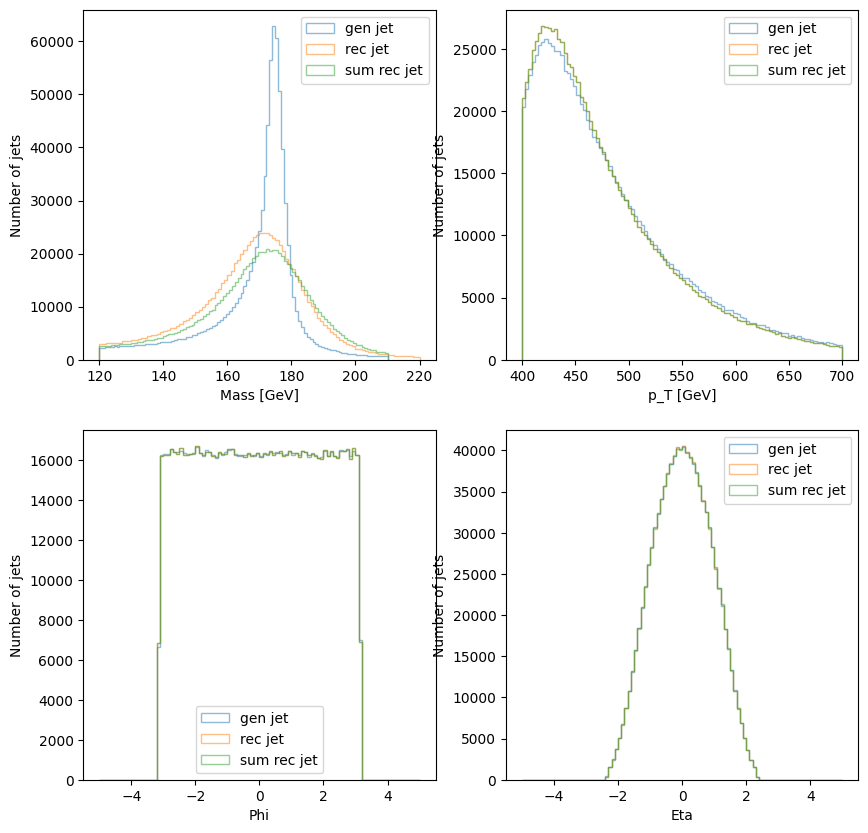

In [ ]:
fig, ax = plt.subplots(2,2,figsize=(10, 10))
ax[0, 0].hist(gen_jets[:,3], bins=100, range=(120, 210), alpha=0.5, label="gen jet", histtype='step')
ax[0, 0].hist(rec_jets[:,3], bins=100, range=(120, 220), alpha=0.5, label="rec jet", histtype='step')
ax[0, 0].hist(summed_rec_jets[:,3], bins=100, range=(120, 210), alpha=0.5, label="sum rec jet", histtype='step')
ax[0, 0].legend()
ax[0, 0].set_xlabel("Mass [GeV]")
ax[0, 0].set_ylabel("Number of jets")
ax[0, 1].hist(gen_jets[:,0], bins=100, range=(400, 700), alpha=0.5, label="gen jet", histtype='step')
ax[0, 1].hist(rec_jets[:,0], bins=100, range=(400, 700), alpha=0.5, label="rec jet", histtype='step')
ax[0, 1].hist(summed_rec_jets[:,0], bins=100, range=(400, 700), alpha=0.5, label="sum rec jet", histtype='step')
ax[0, 1].legend()
ax[0, 1].set_xlabel("p_T [GeV]")
ax[0, 1].set_ylabel("Number of jets")
ax[1, 0].hist(gen_jets[:,1], bins=100, range=(-5, 5), alpha=0.5, label="gen jet", histtype='step')
ax[1, 0].hist(rec_jets[:,1], bins=100, range=(-5, 5), alpha=0.5, label="rec jet", histtype='step')
ax[1, 0].hist(summed_rec_jets[:,1], bins=100, range=(-5, 5), alpha=0.5, label="sum rec jet", histtype='step')
ax[1, 0].legend()
ax[1, 0].set_xlabel("Phi")
ax[1, 0].set_ylabel("Number of jets")
ax[1, 1].hist(gen_jets[:,2], bins=100, range=(-5, 5), alpha=0.5, label="gen jet", histtype='step')
ax[1, 1].hist(rec_jets[:,2], bins=100, range=(-5, 5), alpha=0.5, label="rec jet", histtype='step')
ax[1, 1].hist(summed_rec_jets[:,2], bins=100, range=(-5, 5), alpha=0.5, label="sum rec jet", histtype='step')
ax[1, 1].legend()
ax[1, 1].set_xlabel("Eta")
ax[1, 1].set_ylabel("Number of jets")

/remote/gpu04/petitjean/high-dim-unfolding/venv/lib/python3.11/site-packages/awkward/_nplikes/array_module.py:251: RuntimeWarning: invalid value encountered in divide
  return impl(*broadcasted_args, **(kwargs or {}))


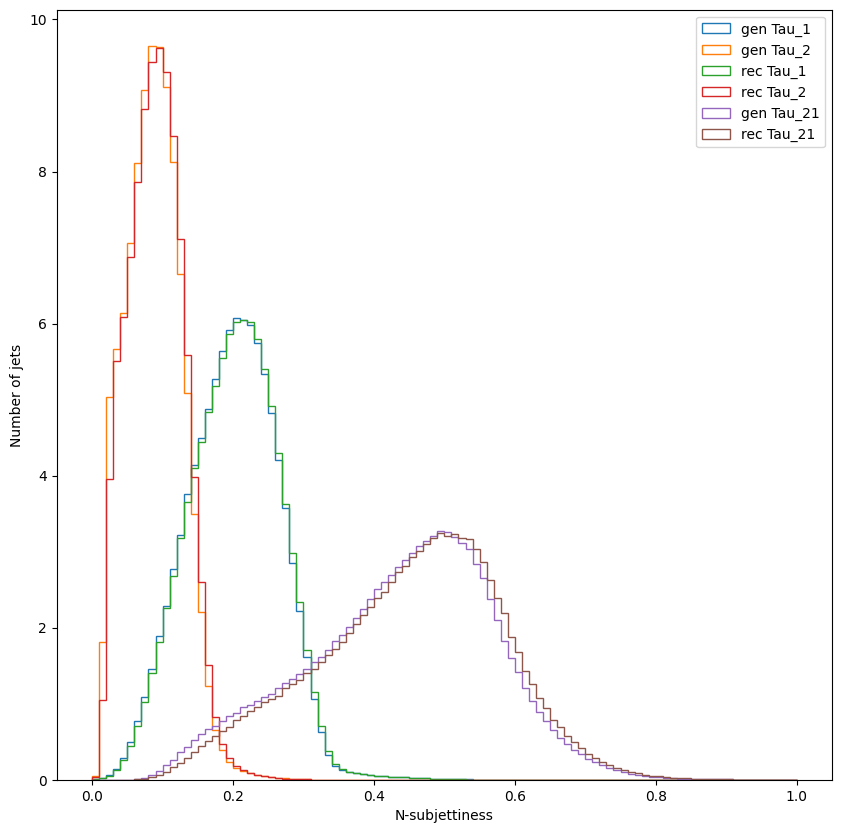

In [ ]:
fig, ax = plt.subplots(figsize=(10, 10))
ax.hist(nsub[..., 0], bins=100, range=(0, 1), label="gen Tau_1", histtype='step', density=True)
ax.hist(nsub[..., 1], bins=100, range=(0, 1), label="gen Tau_2", histtype='step', density=True)
ax.hist(nsub[..., 2], bins=100, range=(0, 1), label="rec Tau_1", histtype='step', density=True)
ax.hist(nsub[..., 3], bins=100, range=(0, 1), label="rec Tau_2", histtype='step', density=True)
ax.hist(nsub[..., 1]/nsub[..., 0], bins=100, range=(0, 1), label="gen Tau_21", histtype='step', density=True)
ax.hist(nsub[..., 3]/nsub[..., 2], bins=100, range=(0, 1), label="rec Tau_21", histtype='step', density=True)
ax.legend()
ax.set_xlabel("N-subjettiness")
ax.set_ylabel("Number of jets")
plt.show()

In [ ]:
computed_nsub = np.array([[compute_nsubjettiness(gen_particles[i][...,[1,2,3,0]], N=1, beta=1.0, R0=1.2),
                          compute_nsubjettiness(gen_particles[i][...,[1,2,3,0]], N=2, beta=1.0, R0=1.2),
                          compute_nsubjettiness(rec_particles[i][...,[1,2,3,0]], N=1, beta=1.0, R0=1.2),
                          compute_nsubjettiness(rec_particles[i][...,[1,2,3,0]], N=2, beta=1.0, R0=1.2)] for i in range(5000)])

In [ ]:
computed_nsub[0], np.array(nsub[0])

(array([0.25756207, 0.06776561, 0.2494873 , 0.07450574]),
 array([0.25756207, 0.0677656 , 0.25046095, 0.07440827]))

/remote/gpu04/petitjean/high-dim-unfolding/venv/lib/python3.11/site-packages/awkward/_nplikes/array_module.py:251: RuntimeWarning: invalid value encountered in divide
  return impl(*broadcasted_args, **(kwargs or {}))


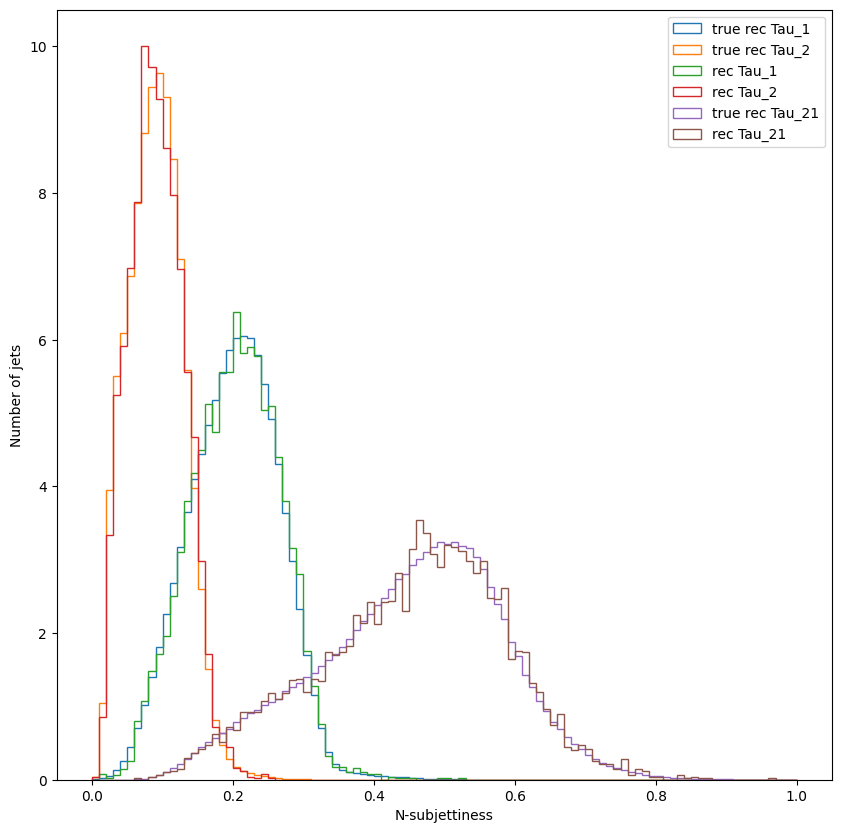

In [ ]:
fig, ax = plt.subplots(figsize=(10, 10))
ax.hist(computed_nsub[..., 0], bins=100, range=(0, 1), label="gen Tau_1", histtype='step', density=True)
ax.hist(computed_nsub[..., 1], bins=100, range=(0, 1), label="gen Tau_2", histtype='step', density=True)
ax.hist(nsub[..., 2], bins=100, range=(0, 1), label="true rec Tau_1", histtype='step', density=True)
ax.hist(nsub[..., 3], bins=100, range=(0, 1), label="true rec Tau_2", histtype='step', density=True)
ax.hist(computed_nsub[..., 2], bins=100, range=(0, 1), label="rec Tau_1", histtype='step', density=True)
ax.hist(computed_nsub[..., 3], bins=100, range=(0, 1), label="rec Tau_2", histtype='step', density=True)
ax.hist(computed_nsub[..., 1]/computed_nsub[..., 0], bins=100, range=(0, 1), label="gen Tau_21", histtype='step', density=True)
ax.hist(nsub[..., 3]/nsub[..., 2], bins=100, range=(0, 1), label="true rec Tau_21", histtype='step', density=True)
ax.hist(computed_nsub[..., 3]/computed_nsub[..., 2], bins=100, range=(0, 1), label="rec Tau_21", histtype='step', density=True)
ax.legend()
ax.set_xlabel("N-subjettiness")
ax.set_ylabel("Density")
ax.set_title("N-subjettiness distributions")
plt.show()